**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install --quiet sweetviz
!{sys.executable} -m pip install --quiet git+https://github.com/michalgregor/class_utils.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import pandas as pd
import sweetviz as sv
from sklearn.model_selection import train_test_split

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
DATA_HOME = "https://github.com/michalgregor/ml_notebooks/blob/main/data/{}?raw=1"

from class_utils.download import download_file_maybe_extract
download_file_maybe_extract(DATA_HOME.format("titanic.zip"), directory="data/titanic")

# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

## Exploratory Data Analysis: Getting an Overview

In this notebook we are going to look at some basics of **exploratory data analysis**  (EDA). EDA is a vitally important tool in the data an analyst's toolbox. It helps the analyst to acquaint themselves with the dataset, to gather insights, to choose what to focus on during the later stages of the analysis, but also to identify potential problems, such as corruptions in the dataset, data that needs more preprocessing for useful features to be extracted, etc.

Also, even though we are going to focus on tabular datasets right now, EDA is done no matter what your dataset looks like: you will still need to explore your data if you working with images, audio, text, etc. The tools required to do so might be a bit different, but it is still be a very necessary step that can help you avoid a lot of problems later on.

### The Dataset

In this example, we will be using the Titanic dataset, which we are now going to load from a CSV file. We can also display the first few rows using `df.head` to make sure that we loaded it correctly.



In [ ]:
df = pd.read_csv("data/titanic/train.csv")
df.head()

### Basic Statistics

Now we should go over all the columns of our dataset and identify whether they are numeric, categorical, textual, etc. We should display the columns' statistics using functions such as pandas's `df.describe()`. E.g. for all numeric variables:



In [ ]:
df.describe()

And individually for each categorical variable:



In [ ]:
df['Embarked'].describe()

This would give us the basic idea of what each variable's distribution looks like.

### Missing Data

We might also want to know whether there are any missing data in our dataset and if so, what percentage of the corresponding rows/columns they make up. This will help inform our decision of whether to drop the rows/columns – if too much data is missing – or to try and impute the values. We can get at the missing values using `df.isnull()`: that will give us a binary array indicating which values are missing.

To get the total number of missing values for each column, we can do `df.isnull().sum()`:



In [ ]:
df.isnull().sum()

Or if we want the percentage, we can divide that by the total number of rows and multiply by one hundred:



In [ ]:
df.isnull().sum() / df.shape[0] * 100

### Automated Reports Using SweetViz

While it is certainly possible to learn about the statistics of the data in this way, there are tools such as Python's `sweetviz` package that make the task a bit easier by automatically creating a report about the dataset, which covers all this basic information and more. To create a report about our dataset, we would call `sv.analyze` and specify that our output column is `'Survived'` (we can get a report without specifying that, but we get additional visualizations in the plots if we do).

Spend some time studying the resulting report for yourself and then we are going to discuss some its more important features below.



In [ ]:
report = sv.analyze(df, target_feat='Survived')
report.show_notebook()

#### DataFrame Summary

The first thing the report shows us is the DataFrame's summary information: the number of rows, duplicates, columns, etc. This view also contains the "Associations" button, which displays the associations matrix.

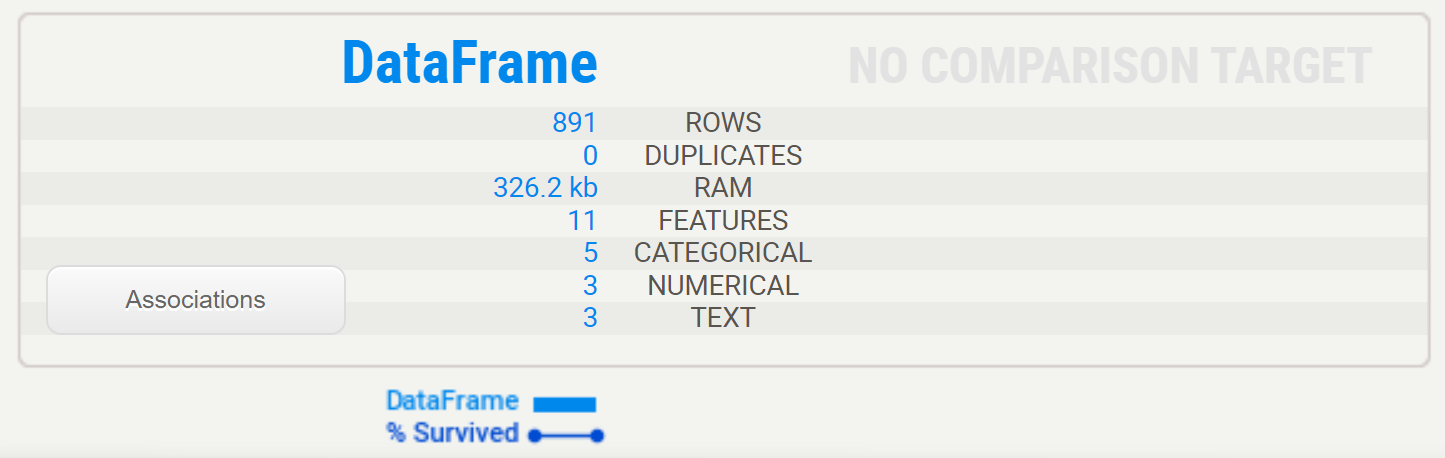

#### Associations

Arguably the most valuable visualization provided by the framework, the associations matrix displays the strengths of relationships between pairs of columns. It is similar to correlation matrices, which are used routinely to display the strengths of linear relationships between pairs of numeric variables using **correlation coefficients** .

The unique thing about the associations matrix in SweetViz is that it also covers numeric vs. categorical (**correlation ratio** ) and categorical vs. categorical (**uncertainty coefficient** ) interactions, so it gives a much fuller picture.

Note that standard numeric vs. numeric correlations are denoted using circles, while categorical interactions are denoted using rectangles. Note that the uncertainty coefficient is asymmetrical: it expresses how much the element on the left provides information on each of the columns.

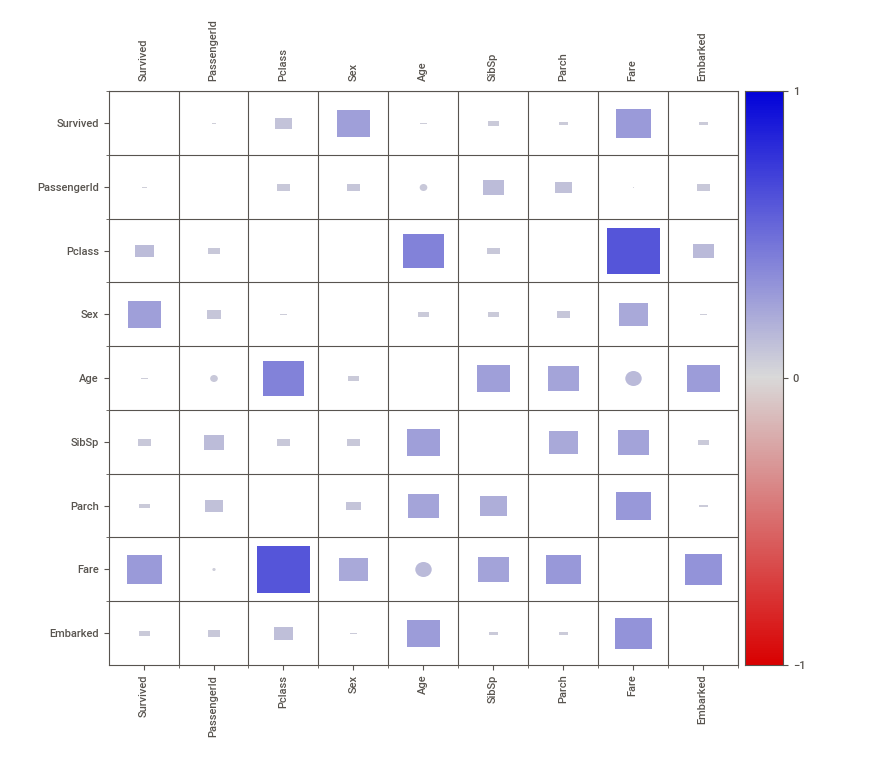

To make sure that we understand what each entry in the associations matrix actually expresses, we are also going to briefly present the definitions of all three kinds of associations.

##### The Correlation Coefficient

There are multiple ways to express correlation, but the most commonly used indicator is probably **Pearson's correlation coefficient** , which is defined through variance and covariance. Let us therefore recall what those are.

**Covariance**  expresses how much two variables vary together, i.e. how much their deviations from their mean values tend to match [[think_stats]](#think_stats):
$$
Cov(X, Y) = \mathbb{E} \left[ (X - \bar X) (Y - \bar Y) \right],
$$

where $X$ and $Y$ are random variables, $\bar X$ and $\bar Y$ are their means and $\mathbb{E}$ denotes the expected value.

**Variance**  is an indicator that expresses how much a variable deviates from its mean in itself [[think_stats]](#think_stats):

$$
\sigma_X^2 = \mathbb{E} \left[ (X - \bar X)^2 \right],
$$
i.e. it is the same as $\sigma_X^2 = \mathit{Var}(X) = Cov(X, X)$. It's square root $\sigma_X$ is called the **standard deviation** .

**Pearson's correlation coefficient**  is defined as [[think_stats]](#think_stats):

$$
r = \frac{Cov(X, Y)}{\sigma_X \sigma_Y},
$$
i.e. it is the covariance of variables $X$ and $Y$, but divided by their standard deviations. This puts it in the range of -1 to +1, where +1 means strong correlation, -1 means strong correlation with a disproportional relationship and 0 means no correlation.

Note also that Pearson's correlation coefficient is **scale invariant**  so there is no need to normalize the variables before it is computed.

##### The Correlation Ratio

Let us suppose that we have a dataset $S$ with $|S|$ samples. If our dataset only contains a single numeric variable $Y \in \mathbb{R}$, we can statistically summarize it by computing its mean $\bar Y$ and variance $\sigma^2 = \mathit{Var}(Y)$. However, if we also have a categorical variable $X \in \{c_1, c_2, ..., c_K\}$, then we can split our data into $K$ groups: one for each category and compute within-category variances.

If we denote the group where $X = c_k$ with $S_k$, we can denote the variance of $Y$ within category $c_k$ with $\sigma^2_k$. If $X$'s categories are highly informative w.r.t. $Y$, i.e. there is a strong relationship, we would expect these within-category variances to be much smaller than the original variance $\sigma^2$. E.g. if $Y$ corresponds to age and $X$ to scholarly status (e.g. pre-school, primary school, ..., post-school), the variance of ages within the primary school category should be much less than the overall variance because primary school children are generally all of roughly similar ages.

The **correlation ratio**  formalizes this intuition and it is defined in the following way [[core_data]](#core_data):

$$
\eta^2 = 1 - \frac{\sigma_w^2}{\sigma^2},
$$
where $\sigma_w^2$ is the average within-category variance defined as [[core_data]](#core_data):

$$
\sigma_w^2 = \sum_{k=1}^K \frac{|S_k|}{|S|} \sigma^2_k,
$$
i.e. we sum up the within-category variances $\sigma^2_k$, weighting them by the proportion $|S_k| / |S|$ of each category in the dataset.

Thus, the correlation ratio is a value ranging from 0 to 1, where 1 means the strongest relationship and 0 means no relationship.

##### The Uncertainty Coefficient

That leaves us with the **uncertainty coefficient** , which provides a way to compute the association between two categorical variables. Let us first recall the definition of entropy and conditional entropy. 

Let $X \in \{c_1, c_2, ..., c_K\}$ be a categorical variable. Its entropy is a measure of the variable's stochasticity (the greater the entropy, the greater the stochasticity) and it is defined as follows [[numerical_recipes]](#numerical_recipes):

$$
H(X) = - \sum_{c_i} p(c_i) \cdot \log_2 p(c_i),
$$
where $p(c_i)$ is the probability of value $c_i$ (or in our case its relative frequency in the dataset).

For conditional entropy, with variable $Y \in \{d_1, d_2, ..., d_K\}$, we first split by that variable's values (much like we did for the correlation ratio) and then do a weighted sum, so we have [[numerical_recipes]](#numerical_recipes):

$$
H(X | Y) = \sum_{d_j} p(d_j) \left[
    - \sum_{c_i} p(c_i | d_j) \cdot \log_2 p(c_i | d_j),
\right]
$$
where $p(c_i | d_j)$ denotes the probability (relative frequency) of $c_i$ given $d_j$.

The **uncertainty coefficient**  is then defined as follows [[numerical_recipes]](#numerical_recipes):

$$
U(X|Y) = \frac{H(X) - H(X|Y)}{H(X)}.
$$
The coefficient's values range from 0 to 1, where 0 means no association and 1 means that $X$ can be completely predicted from $Y$. Note that the uncertainty coefficient is **asymmetrical**  so $U(X|Y) \neq U(Y|X)$.

It is also possible to form a **symmetric version of the uncertainty coefficient**  by taking a weighted average of both $U(X|Y)$ and $U(Y|X)$ [[numerical_recipes]](#numerical_recipes):

$$
U(X, Y) = \frac{
    H(X) U(X|Y) + H(Y) U(Y|X)
}{
    H(X) + H(Y)
}.
$$
#### Individual Variable Tabs

Then come the tabs for all the individual columns. Note the icons in their top left corners: these indicate whether the column is numeric, categorical or textual. The types are generally inferred sensibly, but you should still check to make sure. E.g. for variables such as `SibSp` (the number of siblings or spouses), categorical might or might not be a good type: for categorical variables, the values have no natural ordering. The number of siblings and spouses is a number, there is an order to the values and it might be useful to some methods. So for some purposes it might be best to treat this column as numeric in the rest of the analysis even though it was inferred to be categorical by SweetViz for the purpose of the report.

##### Summary Information

The summary information shown in each tab will tell you how many distinct values there are and what the percentage of missing values is. The missing value field is also colour-coded: it changes colour from green all the way to red based on the percentage. In red columns the vast majority of the values is missing so unless the fact that a value is missing is itself super-informative, they might not be very useful during the analysis.

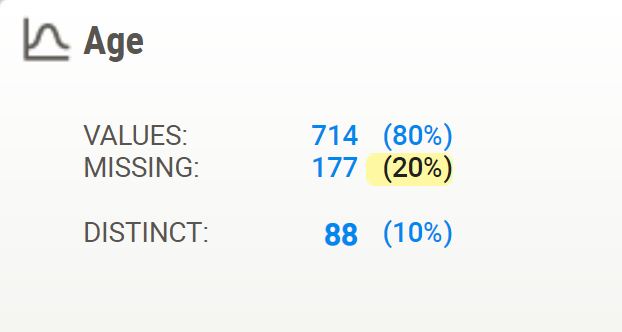

##### Numeric Variables

More detailed information for numeric variables includes their basic statistics, but also a histogram with an overlaid plot of the output column (`"Survived"` in our case). This gives us a fuller idea of what the relationship between the variable and the output is. However, this only works for numeric and binary outputs, not for categorical outputs (where there does not seem to be any very natural way to do a similar kind of visualization) so for multi-class classification problems, we will need different visualization techniques that we are going to cover later.

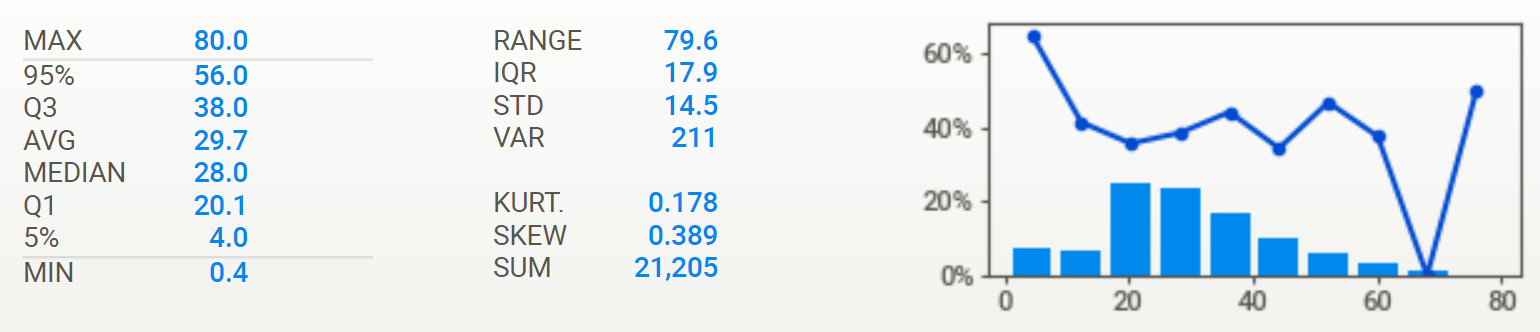

##### Categorical Variables

For categorical variables we again get the distribution and the relationship with the output variable: here indicated by the percentage that survived for each value of the categorical variable.

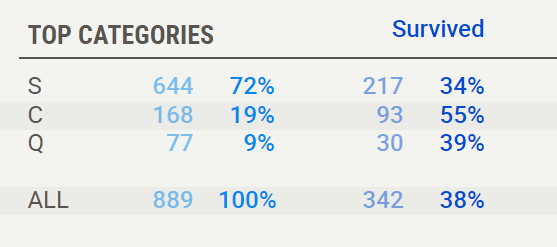

##### Textual Variables

For textual variables, summary visualization are difficult to provide, so what SweetViz does is at least display a few instances of the values along with their number and percentage of occurrence in the dataset. This is useful: e.g. in the case of names it gives us an idea of what format they follow.

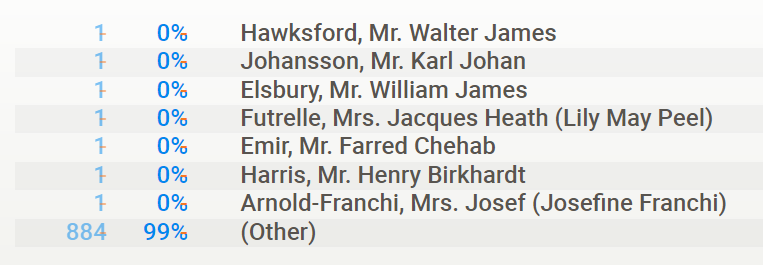

##### Variable Associations

Finally, the individual tabs also show associations to other variables in the form of a table.

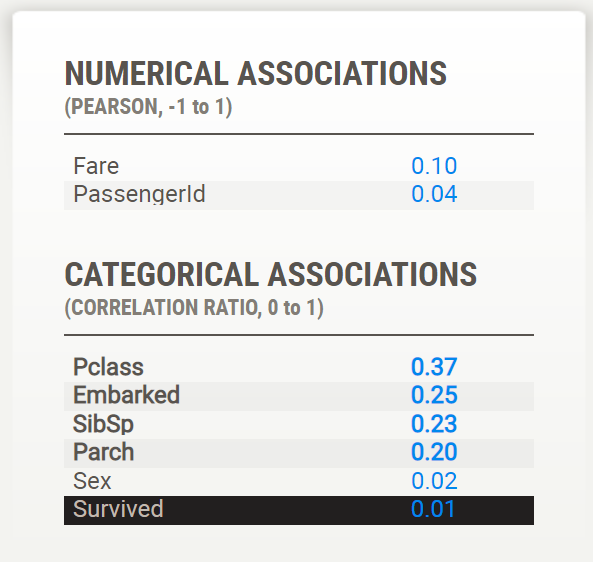

### Saving Reports as a Standalone HTML

Reports can also be exported to a standalone HTML file:



In [ ]:
report.show_html('output/titanic.html', open_browser=False, layout='vertical')

### Comparative Reports: Two Datasets

If we have two similar datasets: typically a training and a testing set, we can also use `sv.compare` instead of `sv.analyze` to give a 2-sided report which compares everything across the two datasets. This can be very useful if we want to make sure that there is no severe statistical disparity between them. It can also give us an idea of how robust some of the visualized relationships are.



In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25,
                     stratify=df["Survived"], random_state=4)

In [ ]:
comparison_report = sv.compare(df_train, df_test, target_feat='Survived')
comparison_report.show_notebook()

### Comparative Reports: Single Dataset

Comparative reports can also be created from a single dataset by splitting it on some attribute, e.g. on `"Sex"` here:



In [ ]:
intra_report = sv.compare_intra(df, df["Sex"] == 'male', ["Male", "Female"], 'Survived')
intra_report.show_notebook()

### References

<a id="think_stats">[think_stats]</a> Downey, A., 2014. Think stats: exploratory data analysis. O'Reilly Media, Inc.

<a id="core_data">[core_data]</a> Mirkin, B., 2019. Core Data Analysis: Summarization, Correlation, and Visualization. Cham: Springer International Publishing.

<a id="numerical_recipes">[numerical_recipes]</a> Press, W.H., Teukolsky, S.A., Vetterling, W.T. and Flannery, B.P., 2007. Numerical recipes 3rd edition: The art of scientific computing. Cambridge university press.

